In [1]:
import os
import pickle
import re

import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import scipy
import seaborn
import tensorflow.keras
from sklearn import preprocessing

import logomaker

# Helper functions

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['legend.fontsize'] = 'small'
pandas.options.display.max_columns = None
pandas.options.display.max_colwidth = None

In [3]:
# Helper functions
def one_hot_encode(sequences, max_seq_len=None, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}

    # Automatically use max length if not specified
    if max_seq_len is None:
        max_seq_len = numpy.max([len(s) for s in sequences])
    
    # Creat empty matrix
    one_hot_seqs = numpy.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        if padding=='left':
            seq = seq[:max_seq_len]
        elif padding=='right':
            seq = seq[-max_seq_len:]
        else:
            raise ValueError(f'padding {padding} not recognized')
        # Convert to array
        seq = seq.lower()
        one_hot_seq = numpy.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            raise ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs

# Load data

In [4]:
datasets = [
    {
        'cell_line': 'HEK293T',
        'replicate': 1,
        'path': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total_reads'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total_reads': 'Reads'},
    },
    {
        'cell_line': 'HEK293T',
        'replicate': 2,
        'path': '../polysome_profiling_sample2019/GSM3130436_egfp_unmod_2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 2,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'HepG2',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_hepg2_r1.csv.gz',
        'cols_to_load': ['UTR', 'rl', 'total'],
        'cols_to_rename': {'rl': 'MRL', 'total': 'Reads'},
    }
]

In [5]:
# Load, preprocess, and compile data
multicol = pandas.MultiIndex(
    levels=[[], [], []],
    codes=[[], [], []],
    names=['Measurement', 'Cell type', 'Replicate'],
)
data_table_combined = pandas.DataFrame(columns=multicol)

for dataset in datasets:
    # Load only desired columns, rename
    data_table = pandas.read_csv(dataset['path'], usecols=dataset['cols_to_load'])
    data_table.rename(columns=dataset['cols_to_rename'], inplace=True)
    data_table['UTR'] = data_table['UTR'].str[:50]
    data_table = data_table.set_index('UTR')
    # Eliminate the large number of sequences with one read
    data_table = data_table[data_table['Reads'] > 1]

    # Convert to multiindex
    data_table = data_table[['Reads', 'MRL']]
    multicol = pandas.MultiIndex.from_product(
        [['Reads', 'MRL'], [dataset['cell_line']], [dataset['replicate']]],
        names=['Measurement', 'Cell type', 'Replicate'],
    )
    data_table.columns = multicol

    # Store
    data_table_combined = data_table_combined.merge(data_table, how='outer', left_index=True, right_index=True)
    
    print("{:,} sequences loaded for cell line {} rep {}.".format(len(data_table), dataset['cell_line'], dataset['replicate']))

# Set NaN reads to zero
data_table_combined['Reads'] = data_table_combined['Reads'].fillna(0)

# Add uATG
data_table_combined['uATG'] = False
data_table_combined.loc[data_table_combined.index.str.contains('ATG'), 'uATG'] = True
# data_table_combined.loc[~data_table_combined.index.str.contains('ATG'), 'uATG'] = False

display(data_table_combined)

326,033 sequences loaded for cell line HEK293T rep 1.
351,575 sequences loaded for cell line HEK293T rep 2.
349,633 sequences loaded for cell line T cells rep 1.
352,724 sequences loaded for cell line T cells rep 2.
789,594 sequences loaded for cell line HepG2 rep 1.


Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,4.0,6.436631,False
AAAAAAAAAAACAAGAACCCAGGTGGGTCTAGAGAAGGGATAGAAGCTCC,17.0,7.925491,28.0,7.464286,0.0,NaN,0.0,NaN,0.0,NaN,False
AAAAAAAAAAACTAAACAAAGACTAAGCTGCGGTCAGATATGTTAAACAA,11.0,10.011610,16.0,6.125000,0.0,NaN,0.0,NaN,0.0,NaN,True
AAAAAAAAAACTATACTAGGAAAGACATATTGCTAGGGATGCTCTGGGAT,0.0,NaN,0.0,NaN,5.0,0.000000,0.0,NaN,0.0,NaN,True
AAAAAAAAAACTATACTAGGAAAGACATCATGCTAGGGATGCTCTGGGAT,0.0,NaN,2.0,11.000000,0.0,NaN,0.0,NaN,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTGAGTTAGAAAACATTGGATCGGTCCGGGTCAAAGGGGAGATC,481.0,8.692710,159.0,7.050314,56.0,6.170554,111.0,7.805348,292.0,4.882561,False


# Analysis

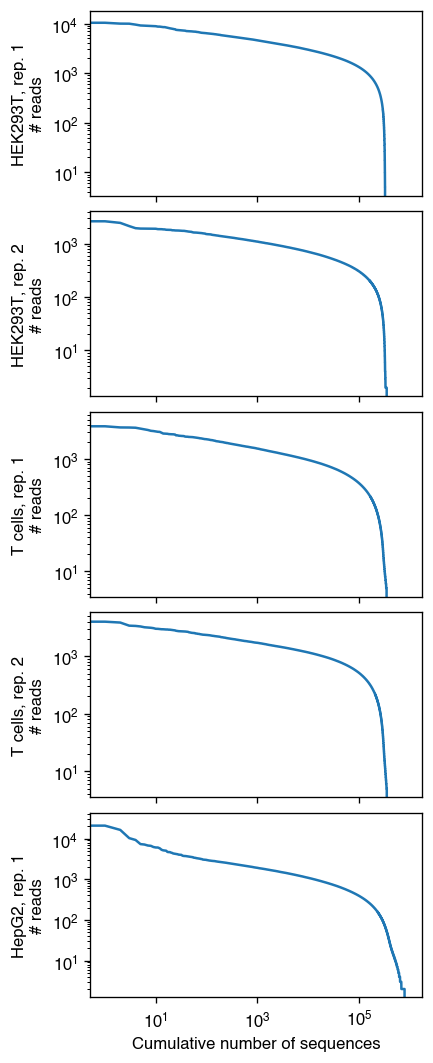

In [6]:
# Plot # reads vs # sequences for each individual dataset
fig, axes = pyplot.subplots(
    len(datasets),
    1,
    figsize=(3.5, 1.75*len(datasets)),
    constrained_layout=True,
)

for i in range(len(datasets)):

    cell_line = datasets[i]['cell_line']
    replicate = datasets[i]['replicate']
        
    # Extract data from selected datasets
    data_to_plot = data_table_combined.loc[
        :,
        (
            slice(None),
            cell_line,
            replicate,
        )
    ]

    # Sort by number of reads
    data_to_plot = data_to_plot.sort_values(('Reads', cell_line, replicate), ascending=False)
    
    ax = axes[i]
    ax.plot(data_to_plot['Reads'])
    ax.set_xscale('log')
    if i==len(datasets) - 1:
        ax.set_xlabel('Cumulative number of sequences')
    else:
        ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylabel(f'{cell_line}, rep. {replicate}\n# reads')

In [7]:
# How many sequences have good quality across all datasets?
data_highq = data_table_combined[data_table_combined['Reads'].min(axis=1) > 100]
data_highq

Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
AAAAAAAAGGAGAATGGCCCCCTGGGACTCAATGTTGAAGATTTCTGCAC,829.0,3.385078,167.0,2.820359,273.0,2.219417,311.0,1.520842,111.0,1.479002,True
AAAAAAAAGTGTAGCGTAGGGCTAGGACCAGAATACAGATATCAGCGGAC,735.0,8.083105,155.0,6.761290,130.0,6.498359,359.0,8.557762,119.0,3.936199,False
AAAAAAAATCGAAGTCATCCTGGTAGCAGCTCGGCAGGGGGTAGCCTTTA,645.0,6.922999,164.0,6.121951,284.0,5.560673,274.0,7.059478,118.0,4.092060,False
AAAAAAACGGGTATCCAGGCGTACGCTCAATTCACTTGTAGGGTATAGAG,2218.0,8.050105,348.0,6.982759,537.0,6.384550,747.0,6.922398,517.0,4.922597,False
AAAAAAACTCTTACCTTCGCACTCAAGTGGCGCCCTAGCCAAAACTCAGC,904.0,7.634494,252.0,6.460317,199.0,7.160299,125.0,6.593979,369.0,4.541844,False
...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGAATCTAGAGTAAACCACGGAAAGCGCAGGGGGGATTCTGTAAA,746.0,8.079362,177.0,6.570621,119.0,5.509059,308.0,8.334718,233.0,3.962982,False


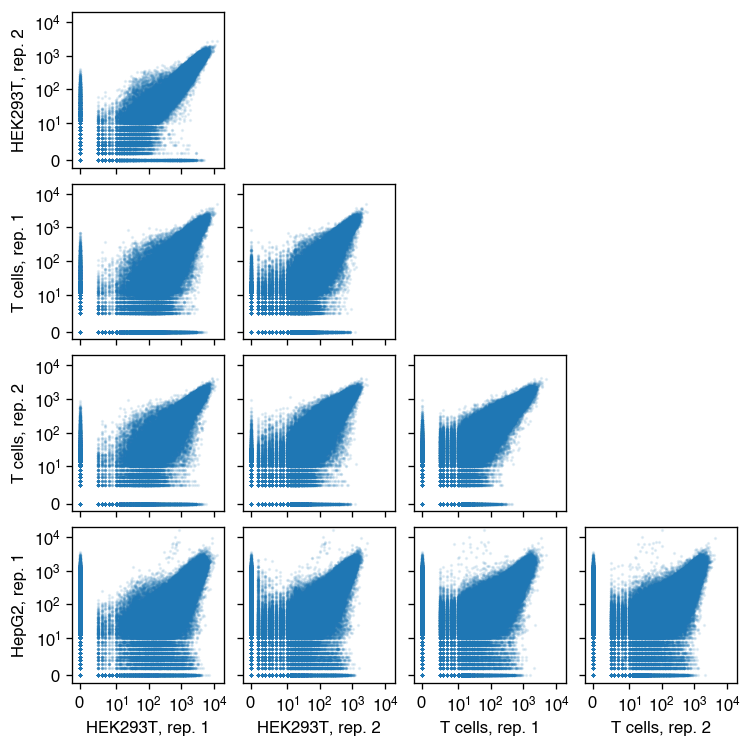

In [8]:
# Plot # reads all vs. all datasets
fig, axes = pyplot.subplots(
    len(datasets),
    len(datasets),
    # figsize=(1.75*len(datasets), 1.75*len(datasets)),
    figsize=(1.5*len(datasets), 1.5*len(datasets)),
    constrained_layout=True,
)

for i in range(len(datasets)):
    for j in range(len(datasets)):
        # Disable axes if above diagonal
        ax = axes[i, j]
        if j >= i:
            ax.set_visible(False)
            
        else:
            # Extract cell line and replicate from each dataset
            cell_line_x = datasets[j]['cell_line']
            replicate_x = datasets[j]['replicate']
            cell_line_y = datasets[i]['cell_line']
            replicate_y = datasets[i]['replicate']
            
            # Extract data from selected datasets
            data_to_plot = data_table_combined.loc[
                :,
                (
                    slice(None),
                    [cell_line_x, cell_line_y],
                    [replicate_x, replicate_y],   
                )
            ]

            # Extract datapoints
            data_x = data_to_plot[('Reads', cell_line_x, replicate_x)].values
            data_y = data_to_plot[('Reads', cell_line_y, replicate_y)].values
            
            # Scatter plot
            ax.scatter(
                data_x,
                data_y,
                alpha=0.1,
                s=1,
                rasterized=True,
            )
            
            # Scale
            ax.set_xscale('symlog', linthresh=10)
            ax.set_yscale('symlog', linthresh=10)
            ax.set_xlim(-2, 2e4)
            ax.set_ylim(-2, 2e4)
            
            # Set axis labels based on position
            if i==len(datasets)-1:
                ax.set_xlabel(f"{cell_line_x}, rep. {replicate_x}")
            else:
                ax.xaxis.set_ticklabels([])
            if j==0:
                ax.set_ylabel(f"{cell_line_y}, rep. {replicate_y}")
            else:
                ax.yaxis.set_ticklabels([])

fig.savefig('reads_all_vs_all.svg', dpi=300, bbox_inches='tight')
fig.savefig('reads_all_vs_all.png', dpi=300, bbox_inches='tight')

In [9]:
# Sort by absolute minimum number of reads
data_table_combined[('Reads', 'min', '')] = data_table_combined.loc[:, 'Reads'].min(axis=1)
data_table_combined = data_table_combined.sort_values(('Reads', 'min', ''), ascending=False)
data_table_combined

Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG,Reads
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,,min
Replicate,1,1,2,2,1,1,2,2,1,1,,
UTR,,,,,,,,,,,,
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,12126.0,3.039939,2633.0,2.688568,4900.0,1.995057,3865.0,2.583809,2955.0,1.846297,True,2633.0
CTAATCGCCCATTTAGGCGCGGATCATCCTATTCAGCCAGTGGATAAGCG,8838.0,7.800806,2802.0,6.458601,2846.0,6.121909,2570.0,6.745352,6627.0,4.595709,False,2570.0
GCGCATCACCACGGCCTCAGAGCAGCCCGCCTAGTACTCTGCCGCTTGTC,6177.0,7.606182,2457.0,6.499796,3057.0,5.536605,2711.0,5.934799,4435.0,4.353461,False,2457.0
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,10368.0,3.895109,2138.0,3.855005,2598.0,3.531917,2395.0,3.925099,2639.0,2.166412,True,2138.0
CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA,5503.0,4.654325,1954.0,3.646878,3610.0,3.057525,2500.0,3.251278,2091.0,2.606412,False,1954.0
...,...,...,...,...,...,...,...,...,...,...,...,...
CCGGAAGGCCGTTTACCGTACAAACGCGCGGTAAAAAAGCGCACTGCGCA,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,4.0,4.000000,False,0.0


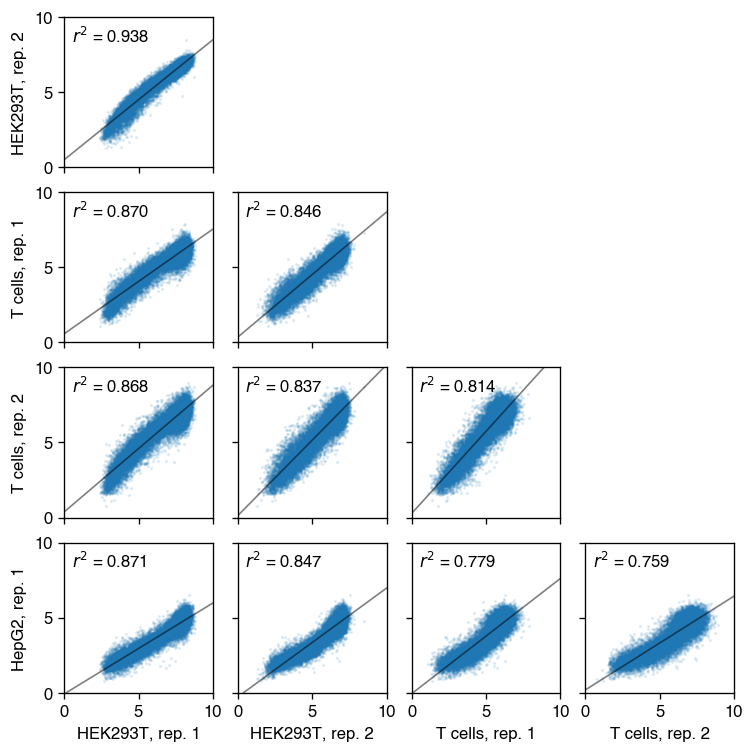

In [10]:
# Plot MRL all vs. all datasets
# Filter datapoints by minimum read #, then randomize order
data_to_plot = data_table_combined.iloc[:20000]
data_to_plot = data_to_plot.sample(frac=1)

# Initialize figure. Size determined by number of columns
fig, axes = pyplot.subplots(
    len(datasets),
    len(datasets),
    # figsize=(1.75*len(datasets), 1.75*len(datasets)),
    figsize=(1.5*len(datasets), 1.5*len(datasets)),
    constrained_layout=True,
)

for i in range(len(datasets)):
    for j in range(len(datasets)):
        # Disable axes if above diagonal
        ax = axes[i, j]
        if j >= i:
            ax.set_visible(False)
            
        else:
            # Extract cell line and replicate from each dataset
            cell_line_x = datasets[j]['cell_line']
            replicate_x = datasets[j]['replicate']
            cell_line_y = datasets[i]['cell_line']
            replicate_y = datasets[i]['replicate']

            # Extract datapoints
            data_x = data_to_plot[('MRL', cell_line_x, replicate_x)].values
            data_y = data_to_plot[('MRL', cell_line_y, replicate_y)].values

            # Calculate regression and r^2
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_x, data_y)
            
            # Scatter plot
            ax.scatter(
                data_x,
                data_y,
                alpha=0.1,
                s=1,
                rasterized=True,
            )

            # Regression line
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_x, data_y)
            ax.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)

            # ax.text(9.5, 0.5, f'$r^2$ = {r_value**2:.3f}', ha='right')
            ax.text(0.5, 9.5, f'$r^2$ = {r_value**2:.3f}', ha='left', va='top')

            # Set axis labels based on position
            if i==len(datasets)-1:
                ax.set_xlabel(f"{cell_line_x}, rep. {replicate_x}")
            else:
                ax.xaxis.set_ticklabels([])
            if j==0:
                ax.set_ylabel(f"{cell_line_y}, rep. {replicate_y}")
            else:
                ax.yaxis.set_ticklabels([])
            ax.set_xlim(0, 10)
            ax.set_xticks([0, 5, 10])
            ax.set_ylim(0, 10)
            ax.set_yticks([0, 5, 10])

fig.savefig('mrl_all_vs_all_fixed_n.svg', dpi=300, bbox_inches='tight')
fig.savefig('mrl_all_vs_all_fixed_n.png', dpi=300, bbox_inches='tight')

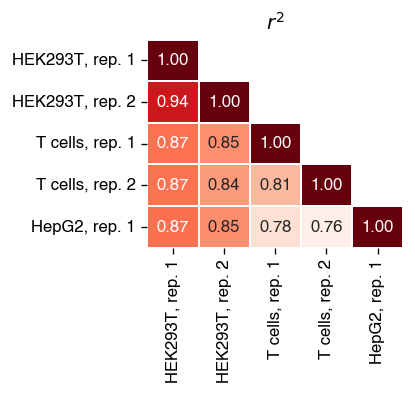

In [11]:
# Plot r^2 of MRL all vs. all datasets
# Filter datapoints by minimum read #, then randomize order
data_to_analyze = data_table_combined.iloc[:20000]
data_to_analyze = data_to_analyze.sample(frac=1)

r2_matrix = numpy.zeros((len(datasets), len(datasets)))
r2_mask = numpy.zeros_like(r2_matrix)

for i in range(len(datasets)):
    for j in range(len(datasets)):

        # Do not calculate if above diagonal
        if j > i:
            r2_mask[i,j] = True
            
        else:
            # Extract cell line and replicate from each dataset
            cell_line_x = datasets[j]['cell_line']
            replicate_x = datasets[j]['replicate']
            cell_line_y = datasets[i]['cell_line']
            replicate_y = datasets[i]['replicate']

            # Calculate regression and r^2
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                data_to_analyze[('MRL', cell_line_x, replicate_x)].values,
                data_to_analyze[('MRL', cell_line_y, replicate_y)].values,
            )

            r2_matrix[i, j] = r_value**2

# Make dataframe with axis labels
xlabels = [
    f'{datasets[j]["cell_line"]}, rep. {datasets[j]["replicate"]}'
    for j in range(len(datasets))
]
ylabels = [
    f'{datasets[i]["cell_line"]}, rep. {datasets[i]["replicate"]}'
    for i in range(len(datasets))
]
r2_df = pandas.DataFrame(r2_matrix, index=ylabels, columns=xlabels)

# Plot heatmap
fig, ax = pyplot.subplots(figsize=(2.75, 2.25))
seaborn.heatmap(
    r2_df,
    mask=r2_mask,
    annot=True,
    fmt='0.2f',
    vmin=0.75,
    vmax=1,
    ax=ax,
    cbar=False,
    # cbar_kws={'label': '$r^2$', 'aspect': 15},
    # edgecolors='k',
    linewidths=1,
    cmap='Reds',
)
ax.set_title('$r^2$')

fig.savefig('mrl_r2_heatmap_fixed_n.svg', dpi=300, bbox_inches='tight')
fig.savefig('mrl_r2_heatmap_fixed_n.png', dpi=300, bbox_inches='tight')

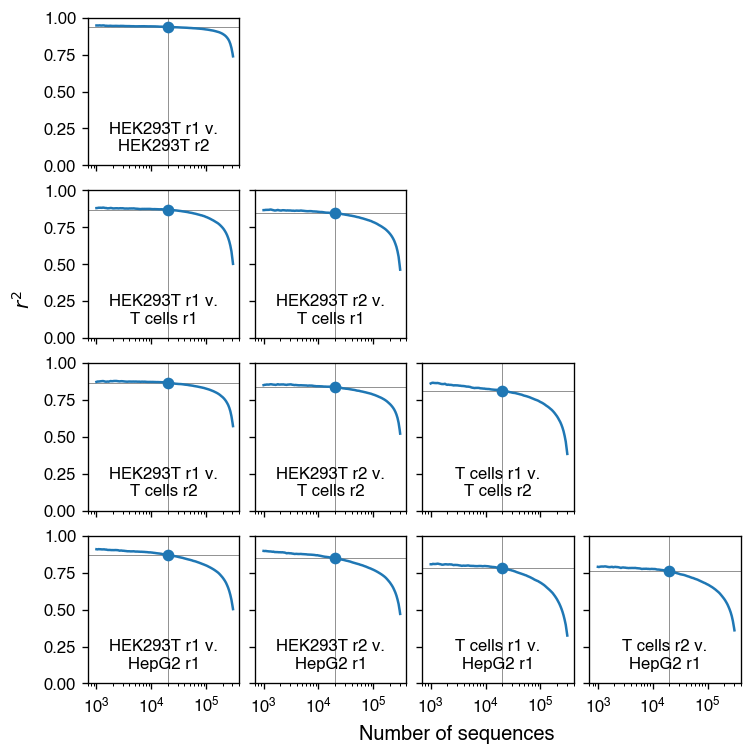

In [12]:
# Plot r^2 for MRL as a function of # reads
# Filter datapoints by minimum read # across dataset pairs
data_to_plot = data_table_combined[data_table_combined[('Reads', 'min', '')] > 0]

# Initialize figure. Size determined by number of columns
fig, axes = pyplot.subplots(
    len(datasets),
    len(datasets),
    # figsize=(2.5*len(datasets), 1.5*len(datasets)),
    figsize=(1.5*len(datasets), 1.5*len(datasets)),
    # sharex=True,
    # sharey=True,
    constrained_layout=True,
)

for i in range(len(datasets)):
    for j in range(len(datasets)):
        
        ax = axes[i, j]

        # Disable axes if above diagonal
        if j >= i:
            ax.set_visible(False)
            
        else:
            # Extract cell line and replicate from each dataset
            cell_line_x = datasets[j]['cell_line']
            replicate_x = datasets[j]['replicate']
            cell_line_y = datasets[i]['cell_line']
            replicate_y = datasets[i]['replicate']

            # # Extract data to plot from selected datasets
            # data_selected = data_table_combined.loc[
            #     :,
            #     (
            #         slice(None),
            #         [cell_line_x, cell_line_y],
            #         [replicate_x, replicate_y],   
            #     )
            # ]

            # # Get minimum number of reads across datasets
            # data_selected[('Reads', 'min', '')] = data_table_combined.loc[:, ('Reads', [cell_line_x, cell_line_y], [replicate_x, replicate_y])].min(axis=1)
            # # Eliminate sequences with no reads in either dataset
            # data_selected = data_selected[data_selected[('Reads', 'min', '')] > 0]
            # # Sort by minimum read #
            # data_selected = data_selected.sort_values(('Reads', 'min', ''), ascending=False)

            read_th_list = 10**numpy.arange(3, numpy.log10(len(data_to_plot)), 0.02)
            read_th_list = [int(read_th) for read_th in read_th_list]
            if read_th_list[-1] < len(data_to_plot):
                read_th_list.append(len(data_to_plot))
            
            r2_list = []
            for read_th in read_th_list:

                # Apply threshold
                data_th = data_to_plot.iloc[:read_th]

                # Calculate regression and r^2
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                    data_th[('MRL', cell_line_x, replicate_x)].values,
                    data_th[('MRL', cell_line_y, replicate_y)].values,
                )

                r2_list.append(r_value**2)

            # Calculate r^2 for the selected threshold number, to be shown with a dot
            read_th_dot = 20000
            data_th_dot = data_to_plot.iloc[:read_th_dot]
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                data_th_dot[('MRL', cell_line_x, replicate_x)].values,
                data_th_dot[('MRL', cell_line_y, replicate_y)].values,
            )
            r2_th_dot = r_value**2

            # Plot r^2
            plot_lines = ax.plot(
                read_th_list,
                r2_list,
                # color='k',
                # marker='o',
            )

            # Plot selected r^2
            ax.plot([read_th_dot], [r2_th_dot], linestyle='', marker='o', color=plot_lines[0].get_color())
            ax.axvline(read_th_dot, color='gray', linewidth=0.5, zorder=-1)
            ax.axhline(r2_th_dot, color='gray', linewidth=0.5, zorder=-1)

            ax.set_xscale('log')
            ax.set_xlim(7e2, 4e5)
            ax.set_ylim(0, 1.)

            axis_label = f'{cell_line_x} r{replicate_x} v.\n{cell_line_y} r{replicate_y}'
            axis_label_xpos = scipy.stats.gmean([ax.get_xlim()[0], ax.get_xlim()[1]])
            ax.text(axis_label_xpos, 0.1, axis_label, ha='center')
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            # ax.set_title(axis_label, fontsize='medium', loc='left')

            if i==len(datasets)-1:
                pass
                #ax.set_xlabel(f"{cell_line_x}, rep. {replicate_x}")
            else:
                ax.xaxis.set_ticklabels([])
            if j==0:
                pass
                #ax.set_ylabel(f"{cell_line_y}, rep. {replicate_y}")
            else:
                ax.yaxis.set_ticklabels([])

fig.supxlabel('Number of sequences')
fig.supylabel('$r^2$')

fig.savefig('mrl_r2_vs_n_seqs.svg', dpi=300, bbox_inches='tight')
fig.savefig('mrl_r2_vs_n_seqs.png', dpi=300, bbox_inches='tight')

With uAUG    11287
No uAUG       8713
Name: uATG string, dtype: int64


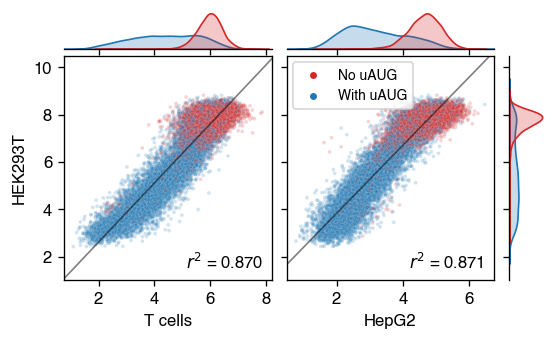

In [13]:
# Plot cell line vs. cell line
cell_lines_x = ['T cells', 'HepG2']
cell_line_y = 'HEK293T'

# Filter datapoints by minimum read #, then randomize order
data_to_plot = data_table_combined.iloc[:20000]
data_to_plot = data_to_plot.sample(frac=1)
data_to_plot['uATG'] = data_table_combined['uATG'].astype(bool)
# Assign whether uAUGs are present in the sequence
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
print(data_to_plot['uATG string'].value_counts())

marginal_size_ratio = 6
fig = pyplot.figure(figsize=(2.5*len(cell_lines_x), 2.8))
gs = fig.add_gridspec(
    2,
    len(cell_lines_x) + 1, 
    width_ratios=[marginal_size_ratio]*len(cell_lines_x) + [1],
    height_ratios=(1, marginal_size_ratio),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.1,
    hspace=0.05,
)

for cell_line_x_idx, cell_line_x in enumerate(cell_lines_x):
    # ax = axes[cell_line_x_idx]
    ax_joint = fig.add_subplot(gs[1, cell_line_x_idx])
    ax_marginal_x = fig.add_subplot(gs[0, cell_line_x_idx])
    if cell_line_x_idx == (len(cell_lines_x) - 1):
        ax_marginal_y = fig.add_subplot(gs[1, len(cell_lines_x)])
    else:
        ax_marginal_y = None

    # Redefine columns for scatterplot
    xcol_name = f"{cell_line_x}"
    ycol_name = f"{cell_line_y}"
    data_pair = data_to_plot[[('MRL', cell_line_x, 1), ('MRL', cell_line_y, 1), ("uATG string", '', '')]]
    data_pair.columns = [xcol_name, ycol_name, "uATG string"]

    # Plot joint scatter plot
    ax_joint = seaborn.scatterplot(
        data=data_pair,
        x=xcol_name,
        y=ycol_name,
        hue="uATG string",
        palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
        s=5,
        # linewidth=0.2,
        alpha=0.2,
        # edgecolor='white',
        rasterized=True,
        legend='auto' if cell_line_x_idx==(len(cell_lines_x) - 1) else False,
        ax=ax_joint,
    )
    ax_joint.set_ylim(1, 10.5)

    # Regression line
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        data_pair[xcol_name].values,
        data_pair[ycol_name].values,
    )
    ax_joint.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
    r2_text = f'$r^2$ = {r_value**2:.3f}'
    # ax.text(ax_joint.get_xlim()[0] + 0.3, 9.5, r2_text, ha='left')
    ax_joint.text(ax_joint.get_xlim()[1] - 0.3, ax_joint.get_ylim()[0] + 0.5, r2_text, ha='right')
    
    if cell_line_x_idx==(len(cell_lines_x) - 1):
        seaborn.move_legend(ax_joint, 'upper left')
        legend = ax_joint.get_legend()
        # legend.set_title(r2_text)
        legend.set_title(None)
        for lh in legend.legendHandles:
            lh.set_alpha(1)
            lh.set_sizes([10])
    if cell_line_x_idx!=0:
        ax_joint.set_ylabel('')
        ax_joint.set_yticklabels([])

    seaborn.kdeplot(
        data=data_pair,
        x=xcol_name,
        hue="uATG string",
        palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
        legend=False,
        fill=True,
        # element="step",
        # bins=numpy.linspace(ax_joint.get_xlim()[0], ax_joint.get_xlim()[1], 50),
        ax=ax_marginal_x,
    )
    ax_marginal_x.set_xlim(ax_joint.get_xlim())
    ax_marginal_x.spines[['top', 'right', 'left']].set_visible(False)
    ax_marginal_x.set_xlabel('')
    ax_marginal_x.set_ylabel('')
    ax_marginal_x.set_xticklabels([])
    ax_marginal_x.set_yticks([])

    if cell_line_x_idx == (len(cell_lines_x) - 1):
        seaborn.kdeplot(
            data=data_pair,
            y=ycol_name,
            hue="uATG string",
            palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
            legend=False,
            fill=True,
            # element="step",
            # bins=numpy.linspace(ax_joint.get_ylim()[0], ax_joint.get_ylim()[1], 50),
            ax=ax_marginal_y,
        )
        ax_marginal_y.set_ylim(ax_joint.get_ylim())
        ax_marginal_y.spines[['top', 'right', 'bottom']].set_visible(False)
        ax_marginal_y.set_xlabel('')
        ax_marginal_y.set_ylabel('')
        ax_marginal_y.set_yticklabels([])
        ax_marginal_y.set_xticks([])

fig.savefig(f'mrl_vs_mrl_scatter.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_mrl_scatter.png', dpi=300, bbox_inches='tight')